## Kerem Yurtseven
### Womanium - Classiq Final Homework
#### Quantum Walk Operator
##### 24.07.2024

Quantum walk algorithm is a quantum algorithm designed to perform probabilistcs paths which can be helpful to solve mathematical problems, optimize models, imply Monte Carlo simulations. In this homework, a quantum walk operator is created for a 16-node line

This work is derived from the Classiq Bootcamp [1](https://www.youtube.com/watch?v=kHJLwfDUSWI&list=PL_wGNAk5B0pXq98BJBKsbNH2Qjp1lk8dG&index=32) and GitHub files [2](https://github.com/Classiq/classiq-library/blob/main/community/womanium/assignments/sonali_chawla_hw4.ipynb)

#### Edges, Vertices, Shapes

Quantum walk is performed on a classical graph such as shown below

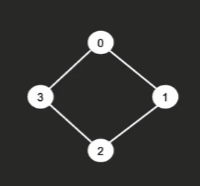

*4-node Circle, Credit: Womanium Quantum + AI Scholarip Program with Classiq*

or on the one that we investigate in this project

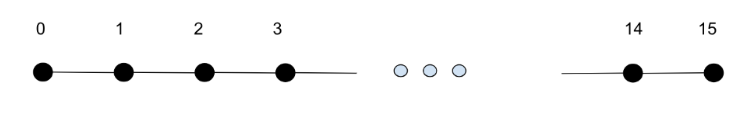

*16-node Line, Credit: Womanium Quantum + AI Scholarip Program with Classiq*

These shapes have two important properties:
- Vertices (V): Nodes on the graph
- Edges    (E): Connected nodes on the graph

For 4-node circle, these properties become:
- V = {0,1,2,3}
- E = {(0,1), (1,2), (2,3), (3,0), + sym.}

For 16-node line, they are
- V = {i where i = [0,15]}
- E = {(i,j) where j = i + 1 and i = [0,14]}

In order to implement Quantum Walk Operator, we need two operators, namely $C$ and $S$.

\begin{align*}
    C := &\sum_{j \in V} \ket{j}\bra{j} \otimes (2\ket{\partial_j}\bra{\partial_j} - I) \\
    S := &\sum_{(j,k)\in E} \ket{j,k}\bra{k,j}
\end{align*}

#### C Operator

This operator attains the propabilities for the walk. For the start and final vertices, there is only one edge to go, and for all the others propability of going to left or right is same.

Below is the code for creating the $C$ operator using a diffuser oracle in 4 qubits since there is $2^4$ vertices

In [19]:
# Import Libraries
from classiq import *

In [20]:
num_ver = 16
size = 4 # log2(16)

In [21]:
# |-> State Creation
@qfunc
def prepare_minus(x: QBit):
  """
  Create a |-> state using X and H gates

  Args:
    x (Qbit): Qubit to apply gates
  """
  X(x)
  H(x)

# Diffuzer oracle
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  """
  Apply a diffuser oracle

  Args:
    aux (Output[QNum]): Auxiliary qubit to store results
    x (QNum): Vertices to be checked
  """
  aux^=(x!=0)

# Zero Diffuzer
@qfunc
def zero_diffuzer(x: QNum):
  """
  Diffuzer zero for the quantum walk

  Args:
    x (QNum): Current Vertice
  """
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)
  
# C Operator for a single vertice
def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    """ 
    C Operator to imply a single vertice

    Args:
      i (int): Current Vertice
      vertices(QNum): All Vertices
      adjacent_vertices (QNum): Adjacent Vertices
    """
    
    prob = [0] * num_ver

    # Final Node
    if i == 0:
        prob[i + 1] = 1.0

    # Initial Node
    elif i == num_ver - 1:
        prob[i - 1] = 1.0
    else:
        prob[i - 1] = 0.5
        prob[i + 1] = 0.5
        
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

# C Opeartor for all vertices
@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    """ 
    Apply C_iteration to all vertices

    Args:
      vertices (QNum): All Vertices
      adjacent_vertices (QNum): Adjacent Vertices
    """
    for i in range(num_ver):
      C_iteration(i,vertices,adjacent_vertices)

#### S Operator

This operator perform the walk based on the probability coming from the $C$ operator

Below is the code for creating the $S$ operator

In [22]:
# Check Adjacency
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    """
    Check the adjacency between two vertices.

    Args:
      res (Output[QBit]): Store the check result
      vertices (QNum): All Vertices
      adjacent_vertices (QNum): Adjacent Vertices
    """
    res |= (((vertices+adjacent_vertices)%2) ==1)

# Swap the values
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    """
    Swaps the values, so imply the walk

    Args:
        x (QArray[QBit]): First Vertice
        y (QArray[QBit]): Second Vertice
    """
    repeat(count= x.len,
      iteration= lambda i: SWAP(x[i],y[i]))
  
# Check vertices and apply SWAP
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    """
    SWAP the adjacent vertices
    
    Args:
        vertices (QNum): All Vertices
        adjacent_vertices (QNum): Adjacent Vertices
    """
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))


#### Synthesize

Create the main model and synthesize the program

In [23]:
# Main Function
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    """
    Perform the quantum random walk operator
    
    Args:
        vertices (Output[QNum]): All Vertices
        adjacent_vertices (Output[QNum]): Adjacent Vertices
    """
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)
    
    C_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/d986106e-a0d2-4a11-bdab-1bdd48de1af7?version=0.43.3


#### Results

Synthesizing the algorithm creates the following cirucit

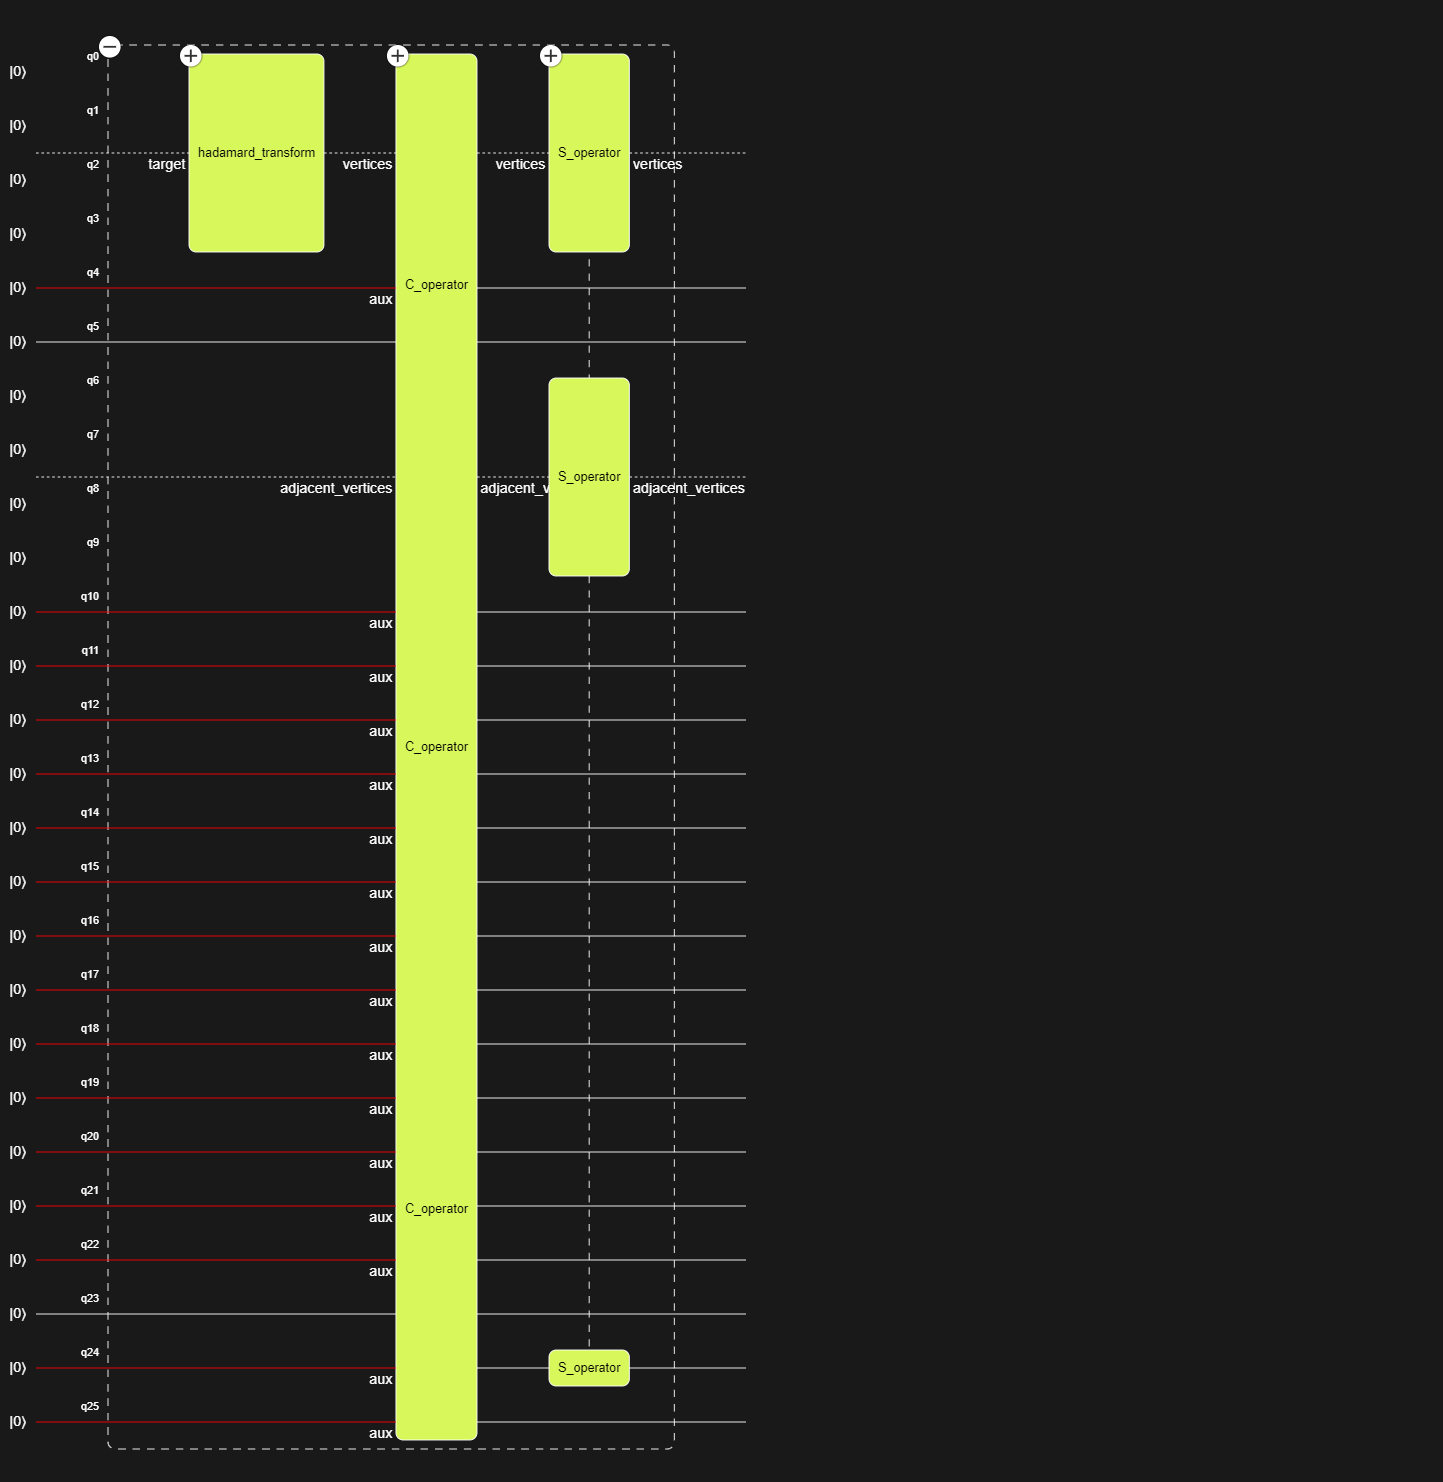

As expected, there is a hadamard transform for vertices at the start to create a equal superposition between different verticies and then operators are implied in turn. Expanding the $C$ Operator

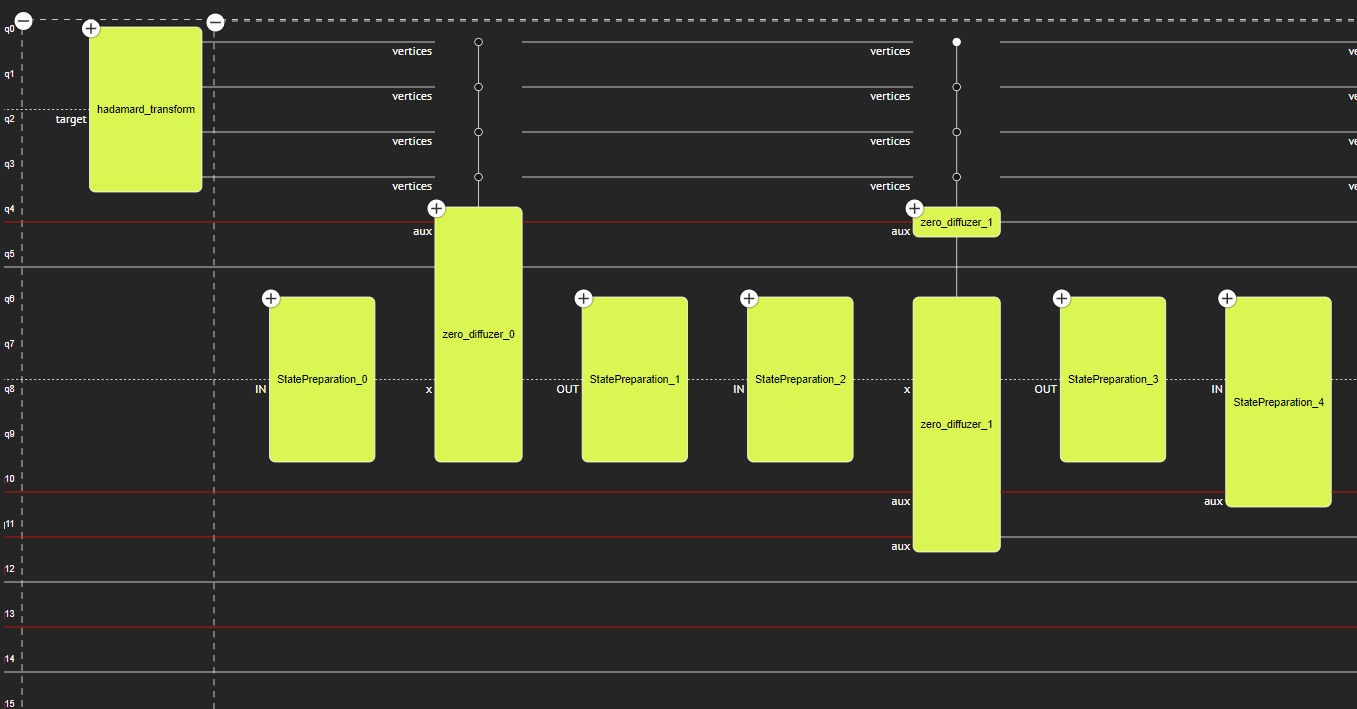

It can be seen that for each vertice, state preparation block creates probabilities for adjacent vertices and zero diffusion block applies the diffusion operator

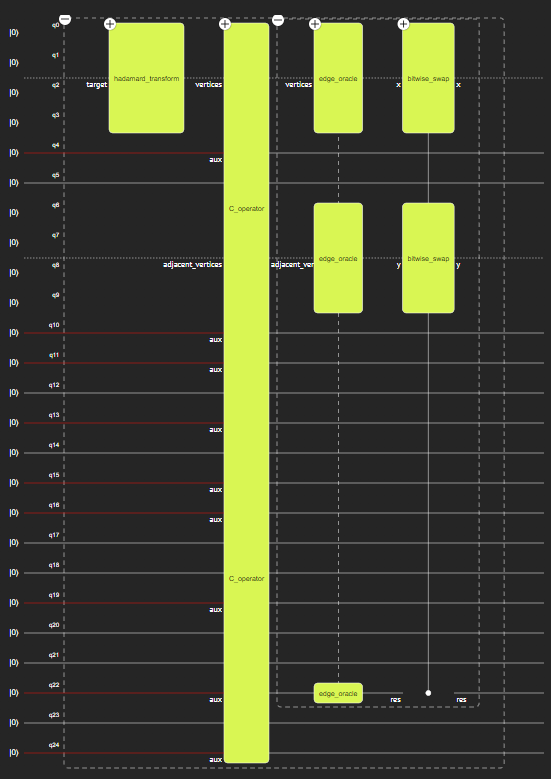

Lastly, $S$ operator checks the adjacency of two vertices and imply the SWAP accordingly. "res" qubit is used to control the check

